### ddG Prediciton and analysis

Free energy of unfolding (dG = ΔG): Change in Gibbs free energy going from the folded to the unfolded state; this parameter belongs to the thermodynamic stability.

In this Jupyter Notebook, ΔG values are predicted for the wild type and all single mutations, and the differences between the ΔG values of the wild type and the mutated sequences are calculated. The results are saved as a .csv file. Analyses are then performed including a correlation analysis.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import ranksums

import pyrosetta; pyrosetta.init()
import pyrosetta
from Bio.PDB import PDBParser, PDBIO
import pandas as pd
import os
from pyrosetta.rosetta.protocols.minimization_packing import MinMover
from pyrosetta.rosetta.core.kinematics import MoveMap
from pyrosetta.rosetta.protocols.relax import FastRelax

PyRosetta-4 2023 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python310.Release 2023.27+release.e3ce6ea9faf661ae8fa769511e2a9b8596417e58 2023-07-07T12:00:46] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python310.Release r353 2023.27+release.e3ce6ea e3ce6ea9faf661ae8fa769511e2a9b8596417e58 http://www.pyrosetta.org 2023-07-07T12:00:46
core.init: command: PyRosetta -ex1 -ex2aro -database /home/rebeccalinux/miniconda3/lib/python3.10/site-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-387171822 seed_offset=0 real_seed=-387171822 thread_index=0
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=-387171822 RG_type=mt19937


In [3]:
#reload the datafame and create new columns (old AA, position and new AA)
df_GFP_unaltered = pd.read_csv('/mnt/c/Users/uni.rebecca.ress/Documents/rebecca.ress/Universität Heidelberg/4. Fachsemester/4. Fachsemester/Bioinformatik Projekt Niopek/Daten/GFP_AEQVI_Sarkisyan_2016.csv')

df_GFP_single = df_GFP_unaltered[~df_GFP_unaltered['mutant'].str.contains(':')]
df_GFP_single_split = df_GFP_single.copy()
df_GFP_single_split[['old AA', 'Position', 'new AA']] = df_GFP_single['mutant'].str.extract(r'(\w)(\d+)(\w)')

print(df_GFP_single_split)

      mutant                                   mutated_sequence  DMS_score  \
4        K3R  MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.738586   
48       K3Q  MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.750487   
703      K3E  MSEGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.666278   
924      K3M  MSMGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.698336   
1160     K3T  MSTGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.629775   
...      ...                                                ...        ...   
51709  Y237N  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.809468   
51710  Y237C  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.760217   
51711  Y237D  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.754101   
51712  Y237F  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.673173   
51713  Y237H  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.735417   

       DMS_score_bin old AA Position new AA  
4                

In [73]:
# Set up PyRosetta
pyrosetta.init()

# Pfad zur PDB-Datei
pdb_file = '/mnt/c/Users/uni.rebecca.ress/Documents/rebecca.ress/Universität Heidelberg/4. Fachsemester/4. Fachsemester/Bioinformatik Projekt Niopek/Daten/WT_avGFP.pdb'

# Create a PDB parser object
parser = PDBParser()

# Open the Biopython PDB object
biopython_structure = parser.get_structure('protein', pdb_file)

# Create a temporary PDB file
temp_pdb_file = 'temp.pdb'

# Create a PDBIO object
pdbio = PDBIO()

# Save the PDB file
pdbio.set_structure(biopython_structure)
pdbio.save(temp_pdb_file)

# Load the protein structure using PyRosetta
pose = pyrosetta.pose_from_pdb(temp_pdb_file)

# Create a ScoreFunction object
scorefxnDDG = pyrosetta.get_fa_scorefxn()

# Relax the structure using FastRelax
relax = FastRelax()
relax.set_scorefxn(scorefxnDDG)
relax.apply(pose)
s0 = scorefxnDDG(pose)

# Create a list for the results
results = []

# Load the wildtype sequence from the pose
wildtype_sequence = pose.sequence()

#Load the DataFrame with the mutations
df = pd.DataFrame({
    'mutant': df_GFP_single_split['mutant'],
    'mutated_sequence': df_GFP_single_split['mutated_sequence'],
    'old_aa': df_GFP_single_split['old AA'],
    'position': df_GFP_single_split['Position'],
    'new_aa': df_GFP_single_split['new AA'],
    'DMS score': df_GFP_single_split['DMS_score']
})

# Convert the value in the "position" column to an integer
df['position'] = df['position'].astype(int)

# Create a list for the results
results = []

# Calculate the ΔG value for each mutation
for index, row in df.iterrows():
    # Check if the position is valid in the sequence
    if row['position'] <= pose.total_residue():
        # Copy the wildtype pose for each mutation
        mutated_sequence = wildtype_sequence
        mutated_pose = pose.clone()

        # Perform the mutation
        position = row['position'] - 1  # Convert to 0-based index
        mutated_sequence = mutated_sequence[:position] + row['new_aa'] + mutated_sequence[position+1:]

        # Perform energy minimization using MinMover
        min_mover = MinMover()
        mm = MoveMap()

        # Set all residues as movable
        for residue in range(1, mutated_pose.total_residue() + 1):
            mm.set_bb(residue, True)
            mm.set_chi(residue, True)

        min_mover.movemap(mm)
        min_mover.score_function(scorefxnDDG)
        min_mover.tolerance(0.01)

        # Perform energy minimization with a reduced number of steps
        num_steps = 3  # Adjust the number of minimization steps
        for step in range(num_steps):
            min_mover.apply(mutated_pose)

        # Perform Monte Carlo sampling
        monte_carlo = pyrosetta.rosetta.protocols.moves.MonteCarlo(scorefxnDDG, 1.0)
        monte_carlo.set_temperature(0.0)
        pose_copy = mutated_pose.clone()
        monte_carlo.boltzmann(pose_copy)

        # Calculate the ΔG value for the mutation
        mutant_energy = scorefxnDDG(mutated_pose)
        ddG = s0 - mutant_energy

        # Add the result to the list
        result = {
            'mutation': f"{row['old_aa']}{row['position']}{row['new_aa']}",
            'ΔG value': mutant_energy,
            'DMS score': row['DMS score'],
            'old AA': row['old_aa'],
            'Position': row['position'],
            'new AA': row['new_aa'],
            'ΔΔG': ddG
        }
        results.append(result)

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Define the path to the CSV file
csv_file_path = '/mnt/c/Users/uni.rebecca.ress/Documents/rebecca.ress/Universität Heidelberg/4. Fachsemester/4. Fachsemester/Bioinformatik Projekt Niopek/Daten/reb09_df_dG_ddG1.csv'

# Save the DataFrame as a CSV file
results_df.to_csv(csv_file_path, index=False)

PyRosetta-4 2023 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python310.Release 2023.27+release.e3ce6ea9faf661ae8fa769511e2a9b8596417e58 2023-07-07T12:00:46] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python310.Release r353 2023.27+release.e3ce6ea e3ce6ea9faf661ae8fa769511e2a9b8596417e58 http://www.pyrosetta.org 2023-07-07T12:00:46
core.init: command: PyRosetta -ex1 -ex2aro -database /home/rebeccalinux/miniconda3/lib/python3.10/site-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-360185444 seed_offset=0 real_seed=-360185444 thread_index=0
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=-360185444 RG_type=mt19937
core.import_po

In [45]:
csv_file_path = '/mnt/c/Users/uni.rebecca.ress/Documents/rebecca.ress/Universität Heidelberg/4. Fachsemester/4. Fachsemester/Bioinformatik Projekt Niopek/Daten/reb09_df_dG_ddG1.csv'
df_ddG_single = pd.read_csv(csv_file_path)

# Ausgabe des DataFrames
print(df_ddG_single)

     mutation    ΔG value  DMS score old AA  Position new AA         ΔΔG
0         K3R -783.379017   3.738586      K         3      R -170.459576
1         K3Q -783.379034   3.750487      K         3      Q -170.459559
2         K3E -783.379041   3.666278      K         3      E -170.459551
3         K3M -783.379064   3.698336      K         3      M -170.459529
4         K3T -783.379081   3.629775      K         3      T -170.459512
...       ...         ...        ...    ...       ...    ...         ...
1074    L236M -783.393562   3.585794      L       236      M -170.445031
1075    L236Q -783.393576   3.748580      L       236      Q -170.445017
1076    L236R -783.393585   3.706509      L       236      R -170.445008
1077    L236V -783.393598   3.715704      L       236      V -170.444995
1078    L236P -783.393612   3.706238      L       236      P -170.444980

[1079 rows x 7 columns]


In [46]:
# Count the number of negative values
negative_count = len(df_ddG_single[df_ddG_single['ΔΔG'] < 0])

# Count the number of positive values
positive_count = len(df_ddG_single[df_ddG_single['ΔΔG'] > 0])

# Print the number of negative and positive values
print("Number of negative values: ", negative_count)
print("Number of positive values: ", positive_count)

Number of negative values:  1079
Number of positive values:  0


In [47]:
# Calculate the minimum and maximum values of ΔΔG
dG_min = df_ddG_single['ΔG value'].min()
dG_max = df_ddG_single['ΔG value'].max()

# Print the minimum and maximum values of ΔΔG
print("Minimum dG:", dG_min)
print("Maximum dG:", dG_max)

Minimum dG: -783.3936123803476
Maximum dG: -783.3790167623416


In [48]:
# Calculate the minimum and maximum values of ΔΔG
ddG_min = df_ddG_single['ΔΔG'].min()
ddG_max = df_ddG_single['ΔΔG'].max()

# Print the minimum and maximum values of ΔΔG
print("Minimum ddG:", ddG_min)
print("Maximum ddG:", ddG_max)

Minimum ddG: -170.4595760162075
Maximum ddG: -170.44498039820155


In [49]:
ddg_min_row = df_ddG_single.loc[df_ddG_single['ΔΔG'].idxmin()]
print("Mutation with min. ddG value", ddg_min_row)

Mutation with min. ddG value mutation            K3R
ΔG value    -783.379017
DMS score      3.738586
old AA                K
Position              3
new AA                R
ΔΔG         -170.459576
Name: 0, dtype: object


In [50]:
ddg_max_row = df_ddG_single.loc[df_ddG_single['ΔΔG'].idxmax()]
print("Mutation with max. ddG value", ddg_max_row)

Mutation with max. ddG value mutation          L236P
ΔG value    -783.393612
DMS score      3.706238
old AA                L
Position            236
new AA                P
ΔΔG          -170.44498
Name: 1078, dtype: object


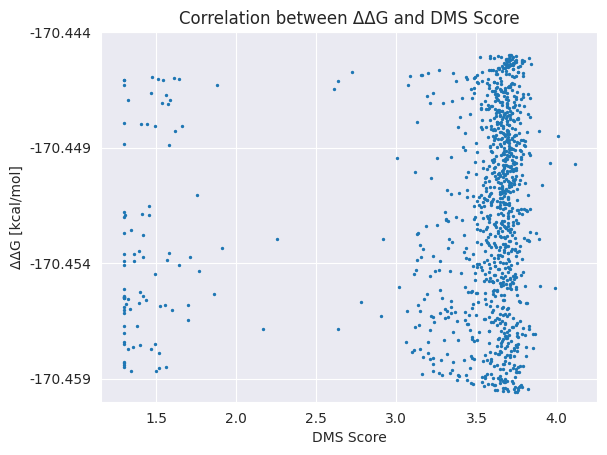

In [51]:
# Create the plot
plt.scatter(df_ddG_single['DMS score'], df_ddG_single['ΔΔG'], s=2)
plt.xlabel('DMS Score')
plt.ylabel('ΔΔG [kcal/mol]')
plt.title('Correlation between ΔΔG and DMS Score')

plt.ylim(bottom=-170.46, top=-170.444)

y_ticks = [-170.459, -170.454, -170.449, -170.444]
plt.gca().yaxis.set_major_locator(ticker.FixedLocator(y_ticks))
plt.gca().yaxis.set_major_formatter(ticker.FixedFormatter(y_ticks))
plt.yticks(y_ticks)

plt.show()

In [52]:
# Extract the relevant columns from the DataFrame
ddG_values = df_ddG_single['ΔΔG']
DMS_score = df_ddG_single['DMS score']

# Calculate the Spearman's rank correlation coefficient
correlation, p_value = spearmanr(ddG_values, DMS_score)

print("Spearman's rank correlation coefficient: ", correlation)
print("p-value: ", p_value)

Spearman's rank correlation coefficient:  0.1646857636530614
p-value:  5.311998701779863e-08


In [53]:
import requests
import pandas as pd

# URL to the GFF file
url = "https://rest.uniprot.org/uniprotkb/P42212.gff"

# Send a GET request and retrieve the data
response = requests.get(url)
data = response.text

# Process the GFF data
feature_list = []

for line in data.split("\n"):
    if line.startswith("P42212"):
        columns = line.split("\t")
        feature_type = columns[2]
        start_pos = columns[3]
        end_pos = columns[4]

        if feature_type in ["turn", "helix", "Beta strand"]:
            feature_list.append([feature_type, start_pos, end_pos])  # Add feature line to the list

# Create a DataFrame
df_structure = pd.DataFrame(feature_list, columns=["Structure", "Start", "End"])

# Print the DataFrame
print(df_structure)

      Structure Start  End
0   Beta strand    12   22
1   Beta strand    25   36
2   Beta strand    41   48
3   Beta strand    50   52
4   Beta strand    92  100
5   Beta strand   101  103
6   Beta strand   105  115
7   Beta strand   118  129
8   Beta strand   132  134
9   Beta strand   141  147
10  Beta strand   148  154
11  Beta strand   158  171
12  Beta strand   176  191
13  Beta strand   198  208
14  Beta strand   215  228


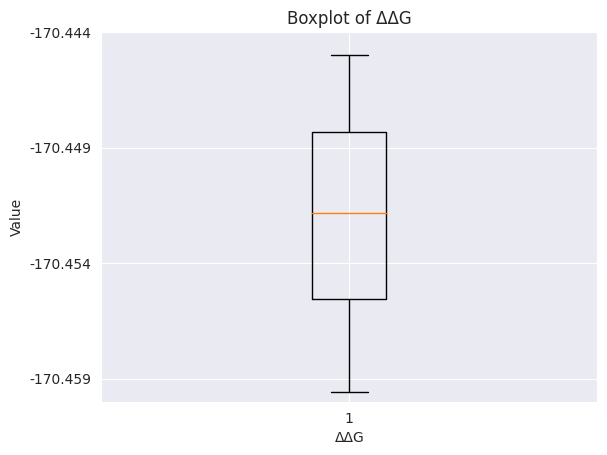

In [54]:
# Create the boxplot
plt.boxplot(df_ddG_single['ΔΔG'])
plt.xlabel('ΔΔG')
plt.ylabel('Value')
plt.title('Boxplot of ΔΔG')

plt.ylim(bottom=-170.46, top=-170.444)

y_ticks = [-170.459, -170.454, -170.449, -170.444]
plt.gca().yaxis.set_major_locator(ticker.FixedLocator(y_ticks))
plt.gca().yaxis.set_major_formatter(ticker.FixedFormatter(y_ticks))
plt.yticks(y_ticks)

# Display the plot
plt.show()

In [55]:
# Calculate the quartiles and the median
q1 = np.percentile(df_ddG_single['ΔΔG'], 25)
q3 = np.percentile(df_ddG_single['ΔΔG'], 75)
median = np.median(df_ddG_single['ΔΔG'])

print("Lower quartile boundary (Q1):", q1)
print("Upper quartile boundary (Q3):", q3)
print("Median:", median)

Lower quartile boundary (Q1): -170.4555486959806
Upper quartile boundary (Q3): -170.4483059308704
Median: -170.45181569560464


Analysing the data with condition ΔΔG < -170.4559700

In [56]:
# Filter the DataFrame for values below the lower
mutations_ddg_lower = df_ddG_single[df_ddG_single['ΔΔG'] < -170.4559700]

# Sort the DataFrame by the ΔΔG values
mutations_ddg_lower_sorted = mutations_ddg_lower.sort_values('ΔΔG')

# Print the sorted DataFrame
print(mutations_ddg_lower_sorted)

    mutation    ΔG value  DMS score old AA  Position new AA         ΔΔG
0        K3R -783.379017   3.738586      K         3      R -170.459576
1        K3Q -783.379034   3.750487      K         3      Q -170.459559
2        K3E -783.379041   3.666278      K         3      E -170.459551
3        K3M -783.379064   3.698336      K         3      M -170.459529
4        K3T -783.379081   3.629775      K         3      T -170.459512
..       ...         ...        ...    ...       ...    ...         ...
236     V55M -783.382559   3.605429      V        55      M -170.456034
237     V55E -783.382578   1.600466      V        55      E -170.456015
238     P56S -783.382594   3.691457      P        56      S -170.455998
239     W57R -783.382602   1.337331      W        57      R -170.455991
240     P58L -783.382621   3.303901      P        58      L -170.455971

[241 rows x 7 columns]


In [58]:
old_aa_lower_counts = mutations_ddg_lower_sorted['old AA'].value_counts()
print(old_aa_lower_counts)

new_aa_lower_counts = mutations_ddg_lower_sorted['new AA'].value_counts()
print(new_aa_lower_counts)

old AA
K    29
V    25
G    24
E    24
L    23
T    22
D    19
F    17
S    12
P    11
I    10
N     6
A     6
Y     6
H     4
C     2
W     1
Name: count, dtype: int64
new AA
A    23
S    22
R    21
V    18
G    15
D    14
E    12
M    12
N    12
T    12
P    12
L    12
I    12
Q    11
K     8
H     7
C     7
Y     5
F     5
W     1
Name: count, dtype: int64


In [59]:
# Convert 'Position' column to integers
mutations_ddg_lower_sorted['Position'] = mutations_ddg_lower_sorted['Position'].astype(int)

# Define the cluster boundaries
cluster_bins = range(1, 242, 10)  # Create clusters in steps of 10 (24 = 238/10)

# Perform the grouping and count the number of mutations in each cluster
cluster_counts = pd.cut(mutations_ddg_lower_sorted['Position'], bins=cluster_bins).value_counts()

cluster_counts_sorted_lower_Q1 = cluster_counts.sort_index()

# Print the sorted cluster ranges
print(cluster_counts_sorted_lower_Q1)

Position
(1, 11]       43
(11, 21]      40
(21, 31]      46
(31, 41]      48
(41, 51]      42
(51, 61]      22
(61, 71]       0
(71, 81]       0
(81, 91]       0
(91, 101]      0
(101, 111]     0
(111, 121]     0
(121, 131]     0
(131, 141]     0
(141, 151]     0
(151, 161]     0
(161, 171]     0
(171, 181]     0
(181, 191]     0
(191, 201]     0
(201, 211]     0
(211, 221]     0
(221, 231]     0
(231, 241]     0
Name: count, dtype: int64


In [60]:
# Function to check the structure based on the position
def check_structure(position):
    structure_info = df_structure[(df_structure['Start'] <= position) & (df_structure['End'] >= position)]
    if not structure_info.empty:
        return structure_info.iloc[0]['Structure']
    else:
        return 'N/A'


df_structure['Start'] = df_structure['Start'].astype(int)
df_structure['End'] = df_structure['End'].astype(int)

# Iterate over the positions of mutations in the DataFrame
for position in mutations_ddg_lower_sorted['Position']:
    # Check the structure based on the position
    mutation_structure = check_structure(position)

    # Print the result
positions = mutations_ddg_lower_sorted['Position']
mutation_structures = [check_structure(position) for position in positions]

df_results_lower = pd.DataFrame({'Position': positions, 'Structure': mutation_structures})
print(df_results_lower)

structure_counts = df_results_lower['Structure'].value_counts()
print(structure_counts)

     Position Structure
0           3       N/A
1           3       N/A
2           3       N/A
3           3       N/A
4           3       N/A
..        ...       ...
236        55       N/A
237        55       N/A
238        56       N/A
239        57       N/A
240        58       N/A

[241 rows x 2 columns]
Structure
Beta strand    149
N/A             92
Name: count, dtype: int64


Q1 > Data < Q3; analysing 50% of data

In [61]:
# Filter the DataFrame for values between the lower Q1 and upper Q2
mutations_ddg_between_Q1_Q3 = df_ddG_single[(df_ddG_single['ΔΔG'] > q1) & (df_ddG_single['ΔΔG'] < q3)]

# Sort the DataFrame by the ΔΔG values
mutations_ddg_between_Q1_Q3_sorted = mutations_ddg_between_Q1_Q3.sort_values('ΔΔG')

# Print the sorted DataFrame
print(mutations_ddg_between_Q1_Q3_sorted)

    mutation    ΔG value  DMS score old AA  Position new AA         ΔΔG
270     S65L -783.383054   3.174363      S        65      L -170.455539
271     S65A -783.383070   3.284241      S        65      A -170.455523
272     Y66C -783.383078   1.301031      Y        66      C -170.455515
273     Y66N -783.383097   1.301031      Y        66      N -170.455496
274     Y66F -783.383113   1.298941      Y        66      F -170.455480
..       ...         ...        ...    ...       ...    ...         ...
804    Q177R -783.390230   3.429738      Q       177      R -170.448363
805    Q177L -783.390245   3.764545      Q       177      L -170.448348
806    L178P -783.390253   3.647913      L       178      P -170.448340
807    L178I -783.390268   3.812832      L       178      I -170.448325
808    L178R -783.390283   3.650243      L       178      R -170.448310

[539 rows x 7 columns]


In [62]:
old_aa_between_Q1_Q3_counts = mutations_ddg_between_Q1_Q3_sorted['old AA'].value_counts()
print(old_aa_between_Q1_Q3_counts)

new_aa_between_Q1_Q3_counts = mutations_ddg_between_Q1_Q3_sorted['new AA'].value_counts()
print(new_aa_between_Q1_Q3_counts)

old AA
K    69
N    62
D    46
I    44
F    42
E    37
Y    32
G    31
H    27
V    25
S    21
R    21
M    19
Q    18
L    12
A    11
T    11
P     7
C     4
Name: count, dtype: int64
new AA
S    43
V    38
L    37
A    36
R    35
G    35
N    32
T    31
C    30
H    29
Y    28
I    27
D    24
E    24
Q    19
M    19
F    17
P    17
K    17
W     1
Name: count, dtype: int64


In [63]:
# Convert 'Position' column to integers
mutations_ddg_between_Q1_Q3['Position'] = mutations_ddg_between_Q1_Q3['Position'].astype(int)

# Define the cluster boundaries
cluster_bins = range(1, 242, 10)  # Create clusters in steps of 10 (24 = 238/10)

# Perform the grouping and count the number of mutations in each cluster
cluster_counts = pd.cut(mutations_ddg_between_Q1_Q3['Position'], bins=cluster_bins).value_counts()

cluster_counts_sorted_between_Q1_Q3 = cluster_counts.sort_index()

# Print the sorted cluster ranges
print(cluster_counts_sorted_between_Q1_Q3)

Position
(1, 11]        0
(11, 21]       0
(21, 31]       0
(31, 41]       0
(41, 51]       0
(51, 61]       0
(61, 71]      26
(71, 81]      49
(81, 91]      42
(91, 101]     48
(101, 111]    47
(111, 121]    37
(121, 131]    49
(131, 141]    46
(141, 151]    58
(151, 161]    50
(161, 171]    60
(171, 181]    27
(181, 191]     0
(191, 201]     0
(201, 211]     0
(211, 221]     0
(221, 231]     0
(231, 241]     0
Name: count, dtype: int64


/tmp/ipykernel_265/3009805109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutations_ddg_between_Q1_Q3['Position'] = mutations_ddg_between_Q1_Q3['Position'].astype(int)


In [64]:
# Function to check the structure based on the position
def check_structure(position):
    structure_info = df_structure[(df_structure['Start'] <= position) & (df_structure['End'] >= position)]
    if not structure_info.empty:
        return structure_info.iloc[0]['Structure']
    else:
        return 'N/A'

df_structure['Start'] = df_structure['Start'].astype(int)
df_structure['End'] = df_structure['End'].astype(int)

# Iterate over the positions of mutations in the DataFrame
for position in mutations_ddg_between_Q1_Q3['Position']:
    # Check the structure based on the position
    mutation_structure = check_structure(position)

    # Print the result
positions = mutations_ddg_between_Q1_Q3['Position']
mutation_structures = [check_structure(position) for position in positions]

df_results_between_Q1_Q2 = pd.DataFrame({'Position': positions, 'Structure': mutation_structures})
print(df_results_lower_Q1)

structure_counts = df_results_between_Q1_Q2['Structure'].value_counts()
print(structure_counts)

     Position Structure
0           3      Turn
1           3      Turn
2           3      Turn
3           3      Turn
4           3      Turn
..        ...       ...
265        64     Helix
266        64     Helix
267        64     Helix
268        65      Turn
269        65      Turn

[270 rows x 2 columns]
Structure
Beta strand    341
N/A            198
Name: count, dtype: int64


Analysing the data with condition ΔΔG > -170.45227815

In [65]:
# Filter the DataFrame for values below the higher
mutations_ddg_higher = df_ddG_single[df_ddG_single['ΔΔG'] > -170.45227815]

# Sort the DataFrame by the ΔΔG values
mutations_ddg_higher_sorted = mutations_ddg_higher.sort_values('ΔΔG')

# Print the sorted DataFrame
print(mutations_ddg_higher_sorted)

     mutation    ΔG value  DMS score old AA  Position new AA         ΔΔG
505     D117N -783.386325   3.758048      D       117      N -170.452268
506     D117V -783.386333   3.653319      D       117      V -170.452260
507     D117E -783.386350   3.699580      D       117      E -170.452243
508     D117G -783.386365   3.729283      D       117      G -170.452227
509     T118A -783.386374   3.580312      T       118      A -170.452219
...       ...         ...        ...    ...       ...    ...         ...
1074    L236M -783.393562   3.585794      L       236      M -170.445031
1075    L236Q -783.393576   3.748580      L       236      Q -170.445017
1076    L236R -783.393585   3.706509      L       236      R -170.445008
1077    L236V -783.393598   3.715704      L       236      V -170.444995
1078    L236P -783.393612   3.706238      L       236      P -170.444980

[574 rows x 7 columns]


In [66]:
old_aa_higher_counts = mutations_ddg_higher_sorted['old AA'].value_counts()
print(old_aa_higher_counts)

new_aa_higher_counts = mutations_ddg_higher_sorted['new AA'].value_counts()
print(new_aa_higher_counts)

old AA
N    73
D    55
I    53
K    52
L    41
G    39
H    35
Y    30
E    29
S    24
V    24
A    20
T    19
M    19
F    18
P    16
Q    14
R    13
Name: count, dtype: int64
new AA
V    48
S    48
R    42
T    38
N    37
A    36
L    34
G    34
D    32
H    29
I    27
P    25
Y    25
E    22
Q    22
C    22
M    19
K    16
F    16
W     2
Name: count, dtype: int64


In [67]:
# Convert 'Position' column to integers
mutations_ddg_higher_sorted['Position'] = mutations_ddg_higher_sorted['Position'].astype(int)

# Define the cluster boundaries
cluster_bins = range(1, 242, 10)  # Create clusters in steps of 10 (24 = 238/10)

# Perform the grouping and count the number of mutations in each cluster
cluster_counts = pd.cut(mutations_ddg_higher_sorted['Position'], bins=cluster_bins).value_counts()

cluster_counts_sorted_higher = cluster_counts.sort_index()

# Print the sorted cluster ranges
print(cluster_counts_sorted_higher)

Position
(1, 11]        0
(11, 21]       0
(21, 31]       0
(31, 41]       0
(41, 51]       0
(51, 61]       0
(61, 71]       0
(71, 81]       0
(81, 91]       0
(91, 101]      0
(101, 111]     0
(111, 121]    14
(121, 131]    49
(131, 141]    46
(141, 151]    58
(151, 161]    50
(161, 171]    60
(171, 181]    47
(181, 191]    41
(191, 201]    48
(201, 211]    45
(211, 221]    42
(221, 231]    46
(231, 241]    28
Name: count, dtype: int64


In [68]:
# Function to check the structure based on the position
def check_structure(position):
    structure_info = df_structure[(df_structure['Start'] <= position) & (df_structure['End'] >= position)]
    if not structure_info.empty:
        return structure_info.iloc[0]['Structure']
    else:
        return 'N/A'

df_structure['Start'] = df_structure['Start'].astype(int)
df_structure['End'] = df_structure['End'].astype(int)

# Iterate over the positions of mutations in the DataFrame
for position in mutations_ddg_higher_sorted['Position']:
    # Check the structure based on the position
    mutation_structure = check_structure(position)

    # Print the result
positions = mutations_ddg_higher_sorted['Position']
mutation_structures = [check_structure(position) for position in positions]

df_results_higher = pd.DataFrame({'Position': positions, 'Structure': mutation_structures})
print(df_results_higher)

structure_counts = df_results_higher['Structure'].value_counts()
print(structure_counts)

      Position    Structure
505        117          N/A
506        117          N/A
507        117          N/A
508        117          N/A
509        118  Beta strand
...        ...          ...
1074       236          N/A
1075       236          N/A
1076       236          N/A
1077       236          N/A
1078       236          N/A

[574 rows x 2 columns]
Structure
Beta strand    398
N/A            176
Name: count, dtype: int64


In [69]:
# Convert 'Position' column to integers
df_ddG_single['Position'] = df_ddG_single['Position'].astype(int)

# Define the neighborhood size
neighborhood_size = 8

# Create an empty list for significant positions
significant_positions = []

# Iterate over each position in the DataFrame
for position in df_ddG_single['Position'].unique():
    # Filter the ΔΔG values for the target position and the neighborhood
    target_ddG = df_ddG_single[df_ddG_single['Position'] == position]['ΔΔG']
    neighbor_ddG = df_ddG_single[(df_ddG_single['Position'] >= position - neighborhood_size) & (df_ddG_single['Position'] <= position + neighborhood_size)]['ΔΔG']

    # Perform the Wilcoxon rank-sum test
    statistic, p_value = ranksums(target_ddG, neighbor_ddG)

    # Check if the result is significant (e.g., p-value less than 0.05)
    if p_value < 0.05:
        significant_positions.append(position)

# Convert significant_positions back to string if needed
significant_positions = [str(pos) for pos in significant_positions]

# Print the significant positions
print("Positions with significantly different ΔΔG distribution compared to the neighborhood:")
print(significant_positions)

Positions with significantly different ΔΔG distribution compared to the neighborhood:
['3', '4', '5', '234', '235', '236']


In [70]:
import pandas as pd

neighborhood_size = 8

# Create an empty list for significant positions and their corresponding information
significant_positions = []

# Iterate over each position in the DataFrame
for position in df_ddG_single['Position'].unique():
    # Filter the ΔΔG values for the target position and the neighborhood
    target_ddG = df_ddG_single[df_ddG_single['Position'] == position]['ΔΔG']
    neighbor_ddG = df_ddG_single[(df_ddG_single['Position'] >= position - neighborhood_size) & (df_ddG_single['Position'] <= position + neighborhood_size)]['ΔΔG']

    # Perform the Wilcoxon rank sum test
    statistic, p_value = ranksums(target_ddG, neighbor_ddG)

    # Check if the result is significant (e.g., p-value less than 0.05)
    if p_value < 0.05:
        # Get the old and new amino acids for the position
        old_aa = df_ddG_single[df_ddG_single['Position'] == position]['old AA'].values[0]
        new_aa = df_ddG_single[df_ddG_single['Position'] == position]['new AA'].values[0]

        # Calculate the statistical measures for the ΔΔG values
        target_mean = target_ddG.mean()
        target_std = target_ddG.std()
        neighbor_mean = neighbor_ddG.mean()
        neighbor_std = neighbor_ddG.std()
        diff_mean = target_mean - neighbor_mean

        # Store the information in a dictionary
        position_info = {
            'Position': position,
            'Old_AA': old_aa,
            'New_AA': new_aa,
            'position_ddG_mean': target_mean,
            'position_ddG_std': target_std,
            'Neighbor_ddG_mean': neighbor_mean,
            'Neighbor_ddG_std': neighbor_std,
            'Difference_mean': diff_mean
        }

        significant_positions.append(position_info)

# Create a DataFrame from the list of significant positions
df_positions = pd.DataFrame(significant_positions)

# Print the DataFrame
print(df_positions)

   Position Old_AA New_AA  position_ddG_mean  position_ddG_std  \
0         3      K      R        -170.459545          0.000025   
1         4      G      S        -170.459484          0.000020   
2         5      E      K        -170.459414          0.000031   
3       234      D      H        -170.445127          0.000019   
4       235      E      K        -170.445067          0.000019   
5       236      L      M        -170.445006          0.000019   

   Neighbor_ddG_mean  Neighbor_ddG_std  Difference_mean  
0        -170.459251          0.000195        -0.000294  
1        -170.459228          0.000208        -0.000256  
2        -170.459189          0.000230        -0.000225  
3        -170.445320          0.000201         0.000193  
4        -170.445296          0.000187         0.000230  
5        -170.445266          0.000169         0.000260  


In [71]:
positive_diff_df = df_positions[df_positions['Difference_mean'] > 0]
positive_diff_count = len(positive_diff_df)
print("Count of positive differences:", positive_diff_count)

positive_diff_df = df_positions[df_positions['Difference_mean'] > 0]
print(positive_diff_df)

Count of positive differences: 3
   Position Old_AA New_AA  position_ddG_mean  position_ddG_std  \
3       234      D      H        -170.445127          0.000019   
4       235      E      K        -170.445067          0.000019   
5       236      L      M        -170.445006          0.000019   

   Neighbor_ddG_mean  Neighbor_ddG_std  Difference_mean  
3        -170.445320          0.000201         0.000193  
4        -170.445296          0.000187         0.000230  
5        -170.445266          0.000169         0.000260  


In [72]:
negative_diff_df = df_positions[df_positions['Difference_mean'] < 0]
negative_diff_count = len(negative_diff_df)
print("Count of negative differences:", negative_diff_count)


negative_diff_df = df_positions[df_positions['Difference_mean'] < 0]
print(negative_diff_df)

Count of negative differences: 3
   Position Old_AA New_AA  position_ddG_mean  position_ddG_std  \
0         3      K      R        -170.459545          0.000025   
1         4      G      S        -170.459484          0.000020   
2         5      E      K        -170.459414          0.000031   

   Neighbor_ddG_mean  Neighbor_ddG_std  Difference_mean  
0        -170.459251          0.000195        -0.000294  
1        -170.459228          0.000208        -0.000256  
2        -170.459189          0.000230        -0.000225  
